# Multilabel Classification on a Diabetes Dataset

Goal statement: I use the diabetes_data.csv dataset from Kaggle.com [1] to perform multilabel classification by predicting whether the patient has diabetes, stroke, and high blood pressure using Keras's Functional API. This is a multilabel, binary classification problem.

In [1]:
# Libraries and imports
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

In [2]:
# model with unedited dataset
raw_ANN = keras.models.load_model('multilabel_clf_unengineered.h5')
# model with BMI categorized and One-Hot encoded
ANN_BMI_cats = keras.models.load_model('ANN_with_BMI_cats.h5')

In [3]:
# Read data
data = pd.read_csv(r'C:\Users\linda\OneDrive\Desktop\diabetes_data.csv')

data.head()
# data.shape

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


I already created an Artificial Neural Network model that keeps the BMI as a continuous feature. It will be loaded for comparison against model with BMI as categories.

Feature Engineering:
 - Cut the BMI feature into categories
  - BMI was converted into categories based on the CDC article "Defining Adult Overweight & Obesity" [2].
 - Convert the features' categories into One-Hot encoded features
  - The Age feature is already categorized as 1-13 (see metadata in [1]); it just needs One-Hot encoding.
 - Add to new dataset and rename columns

In [4]:
# Cut BMI feature into categories for One-Hot encoding
BMI_cuts = pd.cut(x=data['BMI'], bins = [0,18.5,24.9,29.9,34.9,39.9,np.inf],
             labels = list(range(6)))

# One hot encoding with .get_dummies() function
BMI_dummies = pd.get_dummies(BMI_cuts, drop_first=True)


# Add the one-hot encoded features to the original dataset
# with the original BMI feature dropped
data = pd.concat([data.drop('BMI', axis = 1), BMI_dummies], axis=1)


# Renaming BMI weight for clarity
data.rename(columns = {0:'underW', 1:'healthyW', 2:'overW', 3:'obsC1',
                      4:'obsC1', 5:'obsC2'}, inplace = True)

# Create lists of target labels for usage later
TARGET_LABELS = ['Stroke','HighBP','Diabetes']

In [5]:
# One-Hot Encode Age feature
# AGE_dummies = pd.get_dummies(data['Age'], drop_first=True)

# data = pd.concat([data.drop('Age', axis = 1), AGE_dummies], axis=1)

In [6]:
# Convert dataframe subsets to numpy arrays
X = data.drop(['Stroke','HighBP','Diabetes'], axis = 1).to_numpy() # Predictors
y = data[['Stroke','HighBP','Diabetes']].to_numpy()                # 3 targets, binary

In [39]:
# Split into training and testing sets
# Sets will by further split into validation, next
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training set into validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y_train, test_size=0.025, random_state=42)


print(X_valid.shape)
print(X_train.shape)
print(y_valid.shape)
print(y_train.shape)

(1414, 19)
(55139, 19)
(1414, 3)
(55139, 3)


In [34]:
# Number of input features; the number of features for any observation


# Creating sequential model
m = keras.models.Sequential([
 keras.layers.InputLayer(19),                       # One input node per feature, n
 keras.layers.Dense(1000, activation="relu"),   # n^3 nodes
 keras.layers.Dense(300, activation="relu"),      # n^2 nodes
 keras.layers.Dense(3, activation="sigmoid")        # one output node per label
])

In [35]:
X_valid[0].shape

(19,)

In [36]:
# Model summary to inspect number of connections
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1000)              20000     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               300300    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 903       
Total params: 321,203
Trainable params: 321,203
Non-trainable params: 0
_________________________________________________________________


In [37]:
m.compile(loss="binary_crossentropy", # For binary classification
 optimizer="sgd",                     # SGD
 metrics=["accuracy"])                # Display accuracy

In [38]:
history = m.fit(X_train, y_train, epochs=30,
                     validation_data=(X_valid, y_valid), batch_size = 32)

Epoch 1/30
1679/1679 [==============================] - 4s 2ms/step - loss: 0.4879 - accuracy: 0.4470 - val_loss: 0.4503 - val_accuracy: 0.4675
Epoch 2/30
1679/1679 [==============================] - 3s 2ms/step - loss: 0.4455 - accuracy: 0.4330 - val_loss: 0.4375 - val_accuracy: 0.4915
Epoch 3/30
1679/1679 [==============================] - 4s 2ms/step - loss: 0.4367 - accuracy: 0.4344 - val_loss: 0.4339 - val_accuracy: 0.3762
Epoch 4/30
1679/1679 [==============================] - 4s 2ms/step - loss: 0.4321 - accuracy: 0.4327 - val_loss: 0.4270 - val_accuracy: 0.4622
Epoch 5/30
1679/1679 [==============================] - 6s 3ms/step - loss: 0.4297 - accuracy: 0.4303 - val_loss: 0.4315 - val_accuracy: 0.3777
Epoch 6/30
1679/1679 [==============================] - 5s 3ms/step - loss: 0.4277 - accuracy: 0.4286 - val_loss: 0.4237 - val_accuracy: 0.4367
Epoch 7/30
1679/1679 [==============================] - 6s 3ms/step - loss: 0.4260 - accuracy: 0.4304 - val_loss: 0.4255 - val_accuracy:

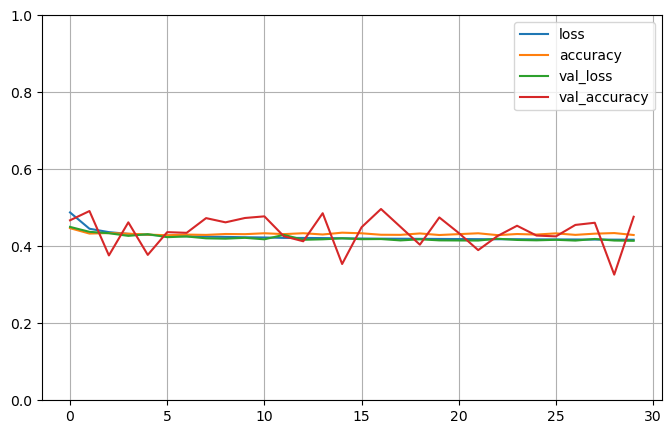

In [40]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()


The first model only used the raw dataset and the validation accuracy had jumps from 10% to 40% and vice versa, frequently, and never converged to a good solution

The model with BMI categorized by the six classes designated by the CDC has its validation accuracy jump much less, but still performs poorly.

Unfortunately, using n^n power of layers for the 3rd model that has 30 features causes over twenty-five million connections. Using nodes 1000 and 300 produces similar results to the previous model that only has BMI One-Hot encoded.

In [41]:
# Predictions, outputs probabilities for current model
predictions_matrix_probs = m.predict(X_valid)

# Predictions, outputs probabilities for unengineered
# X_valid[:,:19] takes only the first 19 features
predictions_matrix_probs2 = ANN_BMI_cats.predict(X_valid[:,:19])

# Predictions, outputs probabilities for unengineered
# X_valid[:,:15] takes only the first 15 features
predictions_matrix_probs3 = raw_ANN.predict(X_valid[:,:15])

In [42]:
print(predictions_matrix_probs[:2])
print(predictions_matrix_probs2[:2])
print(predictions_matrix_probs3[:2])

[[0.0049921  0.07649422 0.04252094]
 [0.07542565 0.8159713  0.7127995 ]]
[[0.00378126 0.0515781  0.03126636]
 [0.02534196 0.5700674  0.49383348]]
[[0.49844697 0.5286261  0.5100912 ]
 [0.37206703 0.6101807  0.4463251 ]]


In [43]:
# LIST COMPREHENSION
# to convert probabilities into binary decision
# 1 if the vector index is >= .5, else put 0
# For each vector in the prediction matrix
predictions_matrix_bin = np.array([[1 if i >= .5 else 0 for i in vector] \
                          for vector in predictions_matrix_probs])

predictions_matrix_bin2 = np.array([[1 if i >= .5 else 0 for i in vector] \
                          for vector in predictions_matrix_probs2])

predictions_matrix_bin3 = np.array([[1 if i >= .5 else 0 for i in vector] \
                          for vector in predictions_matrix_probs3])

In [44]:
def print_multilabel_matrix(matrix):
    for i in range(len(TARGET_LABELS)):
        print(f"CONFUSION MATRIX for {TARGET_LABELS[i]}:")
        print("____________________________")
        print(matrix[i],end = '\n'*2)

In [45]:
print_multilabel_matrix(multilabel_confusion_matrix(predictions_matrix_bin, y_valid))

CONFUSION MATRIX for Stroke:
____________________________
[[1337   77]
 [   0    0]]

CONFUSION MATRIX for HighBP:
____________________________
[[413 131]
 [219 651]]

CONFUSION MATRIX for Diabetes:
____________________________
[[512 189]
 [202 511]]



In [19]:
y_valid[:200]

array([[0., 0., 0.],
       [0., 1., 1.],
       [0., 0., 0.],
       [0., 1., 1.],
       [0., 0., 1.],
       [0., 1., 1.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 1., 1.],
       [0., 0., 0.],
       [0., 1., 1.],
       [0., 1., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 1., 1.],
       [0., 0., 0.],
       [0., 1., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 1

In [46]:
print_multilabel_matrix(multilabel_confusion_matrix(predictions_matrix_bin2, y_valid))

CONFUSION MATRIX for Stroke:
____________________________
[[1337   77]
 [   0    0]]

CONFUSION MATRIX for HighBP:
____________________________
[[501 296]
 [131 486]]

CONFUSION MATRIX for Diabetes:
____________________________
[[614 354]
 [100 346]]



In [48]:
print_multilabel_matrix(multilabel_confusion_matrix(predictions_matrix_bin3, y_valid))

CONFUSION MATRIX for Stroke:
____________________________
[[1181   61]
 [ 156   16]]

CONFUSION MATRIX for HighBP:
____________________________
[[514 594]
 [118 188]]

CONFUSION MATRIX for Diabetes:
____________________________
[[626 576]
 [ 88 124]]



References:

[1] https://www.kaggle.com/datasets/prosperchuks/health-dataset

[2] https://www.cdc.gov/obesity/basics/adult-defining.html

[3] https://apps.who.int/gho/data/node.searo-metadata.AGEGROUP?lang=en

In [24]:
y_train[:30]

array([[0., 1., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 1.],
       [0., 0., 1.],
       [0., 1., 1.],
       [0., 1., 1.],
       [1., 1., 1.],
       [0., 1., 0.],
       [0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 1., 1.],
       [0., 0., 0.],
       [0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 1., 1.],
       [0., 0., 1.],
       [0., 1., 1.],
       [0., 0., 0.],
       [0., 1., 1.],
       [0., 0., 0.],
       [0., 1., 1.],
       [0., 0., 0.]])